# Time Series Prediction

In [70]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Flatten, InputLayer, LSTM
from keras.callbacks import EarlyStopping
import json
import random

## Read in Data

In [71]:
# Read in feature data
with open('../../../../data/feature_database.json') as json_database:
    database = json.load(json_database)
# Concat data
feature_data = None
for i in database:
    # Filter emission data
    if (database[i]['sector'] != 'target_values' and 
        database[i]['sector'] != 'greenhouse_emissions'):
        new_data = pd.read_json(database[i]['data'])
        if feature_data is None:
            feature_data = new_data
        else:
            feature_data = pd.concat([feature_data, new_data], axis=1, join="inner")
    else:
        print(f"Feature not used: {i}")
feature_data = feature_data.values
feature_data = feature_data.astype('float64')
print(f"Shape input features: {feature_data.shape}")
#feature_data.head()

Feature not used: E_Mio.tonnes_CO2
Feature not used: M_Mio.tonnes_CO2
Feature not used: ECO_Mio.tonnes_CO2
Feature not used: Total_CO2_Emission
Shape input features: (111, 40)


In [72]:
# Read in emission data
emission_data = pd.read_csv('../../../../data/greenhouse_emissions/oeko-institut_sektorale_abgrenzung_treibhausgasemissionen_daten_sektor_monthly.csv')
emission_data = emission_data['Total_CO2_Emission'].values
emission_data = emission_data.astype('float64')
# Take only the emissions on which we have indicators
emission_data = emission_data[len(emission_data)-feature_data.shape[0]:]
print(f"Shape output data: {emission_data.shape}")

Shape output data: (111,)


In [73]:
# Convert an array of values into a dataset matrix
def sliding_window(input, output, look_back=1, horizon=1, shuffle=False):
	dataX, dataY = [], []
	if len(input) != len(output):
		raise ValueError('Input and ouput do not have same length!')
	for i in range(len(input)-look_back-horizon):
		dataX.append(input[i:(i+look_back)])
		dataY.append(output[(i+look_back):(i+look_back+horizon)])
	# Shuffle windows
	if shuffle is True:
		dataX, dataY = shuffle(dataX, dataY, random_state=0)
	return np.array(dataX), np.array(dataY)

In [74]:
from keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [75]:
scaler = StandardScaler()
feature_data = scaler.fit_transform(feature_data)

look_back = 12  # months
horizon = 6     # months
split_ratio = 0.8
shuffle = True

# Split into train and test sets
train_size = int(len(feature_data) * split_ratio)
test_size = len(feature_data) - train_size
if test_size < (look_back+horizon):
    raise ValueError('Split ratio too small. Increase test size!')

## Multilayer Perceptron (MLP)

In [76]:
# Regressions forecast model with windowing method
def train_model(trainX, trainY, testX,  testY, lock_back, horizon):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    model = Sequential()
    # Flatten array if input is matrix
    if len(trainX.shape) >= 3:
        model.add(Flatten())
        model.add(Dense(look_back, input_dim=trainX.shape[2]*look_back, activation='relu'))
    model.add(Dense(24, input_dim=look_back, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')#, metrics=[r2_keras])
    model.fit(trainX, trainY, epochs=400, batch_size=2, verbose=2, callbacks=[es])
    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    testScore = model.evaluate(testX, testY, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

    # Generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    return model, trainPredict, testPredict

In [77]:
def train_lstm(trainX, trainY, testX,  testY, lock_back, horizon):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    
    model = Sequential(name='LSTM')
    
    model.add(InputLayer(input_shape=(look_back, trainX.shape[2])))
    model.add(LSTM(128, return_sequences=True, name="LSTM_1"))
    model.add(LSTM(64, return_sequences=False, name="LSTM_2"))
    model.add(Dense(30, activation='relu', name="LSTM_Dense1"))
    model.add(Dense(16, activation='relu', name="LSTM_Dense2"))
    model.add(Dense(8, activation='relu', name="LSTM_Dense3"))    
    model.add(Dense(horizon,activation="linear",name="LSTM_output"))
    
    model.compile(loss='mean_squared_error', optimizer='adam')#, metrics=[r2_keras])
    model.fit(trainX, trainY, epochs=400, batch_size=2, verbose=2, callbacks=[es])
    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    testScore = model.evaluate(testX, testY, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

    # Generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    return model, trainPredict, testPredict

## Input: Emissions

### Create Dataset

In [78]:
# Emissions as input
trainX, trainY = sliding_window(emission_data[0:train_size],
                                emission_data[0:train_size],
                                look_back,
                                horizon)
testX, testY = sliding_window(emission_data[train_size:len(emission_data)],
                              emission_data[train_size:len(emission_data)],
                              look_back,
                              horizon)

In [79]:
print("Shape of data:")
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

Shape of data:
(70, 12)
(70, 6)
(5, 12)
(5, 6)


### Train Model

In [80]:
# Create and fit Multilayer Perceptron model for every indicator
trainPredictPlot = np.empty_like(emission_data)
trainPredictPlot[:] = np.nan
testPredictPlot = np.empty_like(emission_data)
testPredictPlot[:] = np.nan

# Train model and generate predictions
model, trainPredict, testPredict = train_model(trainX, trainY, testX, testY, look_back, horizon)

# Shift train predictions for plotting
for t in range(len(trainPredict)):
    trainPredictPlot[t+look_back:t+look_back+horizon] = trainPredict[t, :]
for t in range(len(testPredict)):
    testPredictPlot[len(trainPredict)+t+look_back+horizon:len(trainPredict)+
                    t+look_back+(horizon*2)] = testPredict[t, :]

Epoch 1/400
 - 0s - loss: 3998.7259
Epoch 2/400
 - 0s - loss: 3074.0052
Epoch 3/400
 - 0s - loss: 1916.5849
Epoch 4/400
 - 0s - loss: 762.6670
Epoch 5/400
 - 0s - loss: 138.6639
Epoch 6/400
 - 0s - loss: 29.1090
Epoch 7/400
 - 0s - loss: 19.5863
Epoch 8/400


C:\Users\Johan\anaconda3\envs\ami-cpu\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 0s - loss: 19.1154
Epoch 9/400
 - 0s - loss: 18.5335
Epoch 10/400
 - 0s - loss: 18.3894
Epoch 11/400
 - 0s - loss: 18.2702
Epoch 12/400
 - 0s - loss: 17.7055
Epoch 13/400
 - 0s - loss: 16.4951
Epoch 14/400
 - 0s - loss: 16.3124
Epoch 15/400
 - 0s - loss: 15.8051
Epoch 16/400
 - 0s - loss: 15.2836
Epoch 17/400
 - 0s - loss: 15.5943
Epoch 18/400
 - 0s - loss: 14.3384
Epoch 19/400
 - 0s - loss: 14.4074
Epoch 20/400
 - 0s - loss: 14.0000
Epoch 21/400
 - 0s - loss: 13.3483
Epoch 22/400
 - 0s - loss: 13.0363
Epoch 23/400
 - 0s - loss: 13.1711
Epoch 24/400
 - 0s - loss: 13.3037
Epoch 25/400
 - 0s - loss: 12.2170
Epoch 26/400
 - 0s - loss: 12.1234
Epoch 27/400
 - 0s - loss: 12.5509
Epoch 28/400
 - 0s - loss: 11.2470
Epoch 29/400
 - 0s - loss: 12.0684
Epoch 30/400
 - 0s - loss: 11.2001
Epoch 31/400
 - 0s - loss: 11.3646
Epoch 32/400
 - 0s - loss: 10.4237
Epoch 33/400
 - 0s - loss: 11.5482
Epoch 34/400
 - 0s - loss: 10.2432
Epoch 35/400
 - 0s - loss: 10.9139
Epoch 36/400
 - 0s - loss: 9.7287


Epoch 245/400
 - 0s - loss: 3.3613
Epoch 246/400
 - 0s - loss: 3.8424
Epoch 247/400
 - 0s - loss: 4.6687
Epoch 248/400
 - 0s - loss: 4.1125
Epoch 249/400
 - 0s - loss: 3.4479
Epoch 250/400
 - 0s - loss: 3.7031
Epoch 251/400
 - 0s - loss: 3.6008
Epoch 252/400
 - 0s - loss: 4.1690
Epoch 253/400
 - 0s - loss: 4.0290
Epoch 254/400
 - 0s - loss: 3.9406
Epoch 255/400
 - 0s - loss: 3.2625
Epoch 256/400
 - 0s - loss: 3.1190
Epoch 257/400
 - 0s - loss: 3.4408
Epoch 258/400
 - 0s - loss: 3.7660
Epoch 259/400
 - 0s - loss: 3.3821
Epoch 260/400
 - 0s - loss: 2.9657
Epoch 261/400
 - 0s - loss: 3.3512
Epoch 262/400
 - 0s - loss: 3.1339
Epoch 263/400
 - 0s - loss: 3.3998
Epoch 264/400
 - 0s - loss: 3.3947
Epoch 265/400
 - 0s - loss: 3.3337
Epoch 266/400
 - 0s - loss: 3.0737
Epoch 267/400
 - 0s - loss: 3.2342
Epoch 268/400
 - 0s - loss: 3.0684
Epoch 269/400
 - 0s - loss: 3.1350
Epoch 270/400
 - 0s - loss: 3.5124
Epoch 271/400
 - 0s - loss: 3.1624
Epoch 272/400
 - 0s - loss: 3.0601
Epoch 273/400
 - 0s 

### Prediction and Plot

Forecast: [[72.20385  71.76307  69.20645  66.0853   63.24192  61.475533]]


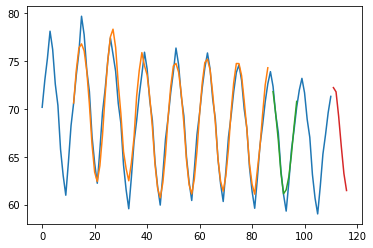

In [81]:
# Forecast predictions
forecastPlot = np.zeros((len(emission_data) + horizon))
forecastPlot[:] = np.nan

X = np.zeros((1, look_back))
X[0] = emission_data[len(emission_data)-look_back:]
predict = model.predict(X)
forecastPlot[len(emission_data):len(emission_data)+horizon] = predict[:]

print(f"Forecast: {predict}")

# Plot baseline, training, test and forecast
plt.plot(emission_data[:])
plt.plot(trainPredictPlot[:])
plt.plot(testPredictPlot[:])
plt.plot(forecastPlot[:])
plt.show()

## Input: Features

### Create Dataset

In [82]:
# Features as input
trainX, trainY = sliding_window(feature_data[0:train_size,:],
                                emission_data[0:train_size],
                                look_back,
                                horizon)
testX, testY = sliding_window(feature_data[train_size:len(feature_data),:],
                              emission_data[train_size:len(emission_data)],
                              look_back,
                              horizon)

In [83]:
print("Shape of data:")
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)
testY

Shape of data:
(70, 12, 40)
(70, 6)
(5, 12, 40)
(5, 6)


array([[71.66739555, 68.89877353, 67.01921089, 63.1472728 , 60.68784891,
        59.03368864],
       [68.89877353, 67.01921089, 63.1472728 , 60.68784891, 59.03368864,
        61.9336371 ],
       [67.01921089, 63.1472728 , 60.68784891, 59.03368864, 61.9336371 ,
        65.2684815 ],
       [63.1472728 , 60.68784891, 59.03368864, 61.9336371 , 65.2684815 ,
        67.30914151],
       [60.68784891, 59.03368864, 61.9336371 , 65.2684815 , 67.30914151,
        69.58895439]])

### Train Model

In [84]:
#Varying number of features

num_of_feats = 10

trainX = trainX[:, :, :num_of_feats]
print(trainX.shape)
testX = testX[:, :, :num_of_feats]
print(testX.shape)

(70, 12, 10)
(5, 12, 10)


In [ ]:
# Create and fit Multilayer Perceptron model for every indicator
trainPredictPlot = np.empty_like(emission_data)
trainPredictPlot[:] = np.nan
testPredictPlot = np.empty_like(emission_data)
testPredictPlot[:] = np.nan



# Train model and generate predictions
model, trainPredict, testPredict = train_lstm(trainX, trainY, testX, testY,
                                               look_back, horizon)

# Shift train predictions for plotting
for t in range(len(trainPredict)):
    trainPredictPlot[t+look_back:t+look_back+horizon] = trainPredict[t, :]
for t in range(len(testPredict)):
    testPredictPlot[len(trainPredict)+t+look_back+horizon:len(trainPredict)+
                    t+look_back+(horizon*2)] = testPredict[t, :]

Epoch 1/400
 - 1s - loss: 4654.2047
Epoch 2/400


C:\Users\Johan\anaconda3\envs\ami-cpu\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 0s - loss: 4004.1996
Epoch 3/400
 - 0s - loss: 1879.7055
Epoch 4/400
 - 0s - loss: 195.9186
Epoch 5/400
 - 0s - loss: 35.1309
Epoch 6/400
 - 0s - loss: 27.9512
Epoch 7/400
 - 0s - loss: 26.6295
Epoch 8/400
 - 0s - loss: 26.6467
Epoch 9/400
 - 0s - loss: 26.8692
Epoch 10/400
 - 0s - loss: 26.5599
Epoch 11/400
 - 0s - loss: 26.8361
Epoch 12/400
 - 0s - loss: 26.5599
Epoch 13/400
 - 0s - loss: 26.9784
Epoch 14/400
 - 0s - loss: 26.7949
Epoch 15/400
 - 0s - loss: 27.7508
Epoch 16/400
 - 0s - loss: 26.7060
Epoch 17/400
 - 0s - loss: 27.4495
Epoch 18/400
 - 0s - loss: 27.1459
Epoch 19/400
 - 0s - loss: 26.9666
Epoch 20/400
 - 0s - loss: 26.7520
Epoch 21/400
 - 0s - loss: 26.3742
Epoch 22/400
 - 0s - loss: 27.4128
Epoch 23/400
 - 0s - loss: 27.4931
Epoch 24/400
 - 0s - loss: 28.2254
Epoch 25/400
 - 0s - loss: 28.1938
Epoch 26/400
 - 0s - loss: 27.9232
Epoch 27/400
 - 0s - loss: 27.3661
Epoch 28/400
 - 0s - loss: 27.8536
Epoch 29/400
 - 0s - loss: 27.6458
Epoch 30/400
 - 0s - loss: 27.2230


### Prediction and Plot

In [ ]:
# Forecast predictions
forecastPlot = np.zeros((len(emission_data) + horizon))
forecastPlot[:] = np.nan

# Features
#X = np.zeros((1, look_back, feature_data.shape[1]))
X = np.zeros((1, look_back, num_of_feats))
#X[0] = feature_data[len(feature_data)-look_back:, :]
X[0] = feature_data[len(feature_data)-look_back:, :10]
predict = model.predict(X)
forecastPlot[len(feature_data):len(feature_data)+horizon] = predict[:]

print(f"Forecast: {predict}")

# Plot baseline, training, test and forecast
plt.plot(emission_data[:])
plt.plot(trainPredictPlot[:])
plt.plot(testPredictPlot[:])
plt.plot(forecastPlot[:])
plt.show()